# [IUM] Dokumentacja wstępna
**Autorzy:**  
Gustaw Malinowski (324872), Kacper Straszak (325234), Aleksandra Szymańska (318733)  
**Data:** 24.11.2024 r.

---

## Oryginalna treść zadania
**Zadanie 10:**  
“Jakiś czas temu wprowadziliśmy konta premium, które uwalniają użytkowników od słuchania reklam. Nie są one jednak jeszcze zbyt popularne – czy możemy się dowiedzieć, które osoby są bardziej skłonne do zakupu takiego konta?”

---

## Analiza z perspektywy Biznesowej

### Opis problemu biznesowego
Naszym celem jest określenie i lepsze zrozumienie profilu osoby skłonnej do zakupu konta premium w oparciu o dane o użytkownikach, ich sesjach użytkowania, artystach, utworach oraz sposobie ich przechowywania zbieranych przez serwis. Na tej podstawie firma będzie mogła podjąć decyzję o strategiach marketingowych skutecznych przy nakłanianiu do zakupu kont premium (personalizacji reklam oraz oferty) i zwiększyć zysk płynący z tego typu oferowanych usług.

---

### Założenia
- Ponieważ klient nie ponosi kosztów, uznajemy, że zwrot z inwestycji w stosunku do kosztów zawsze będzie nieskończony.
- Klient nie dysponuje istniejącym rozwiązaniem, które musielibyśmy "pokonać".
- Model nie musi być interpretowalny, ponieważ klient nie ma możliwości wpływania na zachowania użytkownika wpływające na zakup konta premium, takie jak średni czas słuchania muzyki na sesję.
- Zakładamy zdroworozsądkowe ograniczenia dotyczące prędkości obliczeń (czas obliczeń dla pojedynczego użytkownika nie powinien być zauważalny).

---

### Wymagania klienta
Od strony zastosowań biznesowych klient nie ma jasno sprecyzowanych wymagań. Oczekuje jedynie rozwiązania, które umożliwi mu dostosowanie rekomendacji.  

**Główne wymagania:**
- Dostarczenie gotowego rozwiązania maksymalnie do 17.01.2025.
- Rozwiązanie w postaci mikroserwisu umożliwiającego łatwe wykorzystanie modelu w produkcji.
- Dostarczenie dwóch modeli oraz porównanie ich wyników.
- Wykonanie eksperymentu A/B porównującego dwa modele.

---

### Proponowane biznesowe kryteria sukcesu
Rozwiązanie pozwoli klientowi zwiększyć liczbę zakupów kont premium poprzez precyzyjniejsze targetowanie reklam, zamiast dotychczasowego szerokiego serwowania ich do wszystkich użytkowników.

---

## Analiza z perspektywy modelowania

### Zadanie Modelowania

#### Analiza zadania
Aby zrealizować zadanie biznesowe polegające na określeniu użytkowników skłonnych do zakupu konta premium, definiujemy problem jako klasyfikację – czy użytkownik kupił konto premium, czy nie. Celem jest stworzenie modelu klasyfikacyjnego, który na podstawie danych o użytkownikach pozwala przewidzieć, czy dany użytkownik jest skłonny do zakupu konta premium.

---

#### Analityczne kryterium sukcesu
Model będzie miał większą dokładność niż najprostszy model bazowy. Za cel przyjmujemy dokładność na poziomie 60%.

---

#### Analityczne miary jakości modelu
W trakcie modelowania planujemy wykorzystać: 
1. Macierz Pomyłek  
2. Precyzję modelu  
3. Dokładność klasyfikacji  
4. Wartość F1  

---

### Analiza Danych

#### Dane dostarczone przez klienta
Klient dostarczył nam następujące dane:
- Ulubione gatunki muzyczne użytkowników.
- Miejsce zamieszkania użytkowników.
- Logi interakcji użytkowników z serwisem.
- Baza artystów z uwzględnieniem ich stylów muzycznych.
- Baza utworów wraz z ich charakterystyką i typem przechowywania.

---

#### Wygenerowane atrybuty

In [2]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = 'content/artists.jsonl'
artists = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/sessions.jsonl'
sessions = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/track_storage.jsonl'
track_storage = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/tracks.jsonl'
tracks = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/users.jsonl'
users = pd.read_json(file_path, lines=True, encoding='utf-8')

data = ['artists', 'sessions', 'track_storage', 'tracks', 'users']

# sessions: Index(['timestamp', 'user_id', 'track_id', 'event_type', 'session_id'], dtype='object')
track_id_duration = dict(zip(tracks['id'], tracks['duration_ms']))
# Map values to a new column using a dictionary
sessions['track_len'] = sessions['track_id'].map(track_id_duration)
sessions['duration_ms'] = 0
# [conditions, what to modify] = new value for selected by condtions columns to modify
sessions.loc[sessions['event_type'] == "Play", 'duration_ms'] = sessions['track_len']
# @TODO see time between play and skip and in the duration ms put - only the time that the song was plahyed
sessions.loc[sessions['event_type'] == "Skip", 'duration_ms'] = -sessions['track_len']

sessions['timestamp'] = pd.to_datetime(sessions['timestamp'])
sessions['date'] = sessions['timestamp'].dt.strftime('%Y-%m-%d')
sessions['month'] = sessions['timestamp'].dt.strftime('%Y-%m')

sessions['song_played_in_full'] = sessions['event_type'].map({"Play":1,"Skip":-1}).fillna(0)
sessions['song_liked'] = sessions['event_type'].map({"Like":1}).fillna(0)
sessions['Advertisment_played'] = sessions['event_type'].map({"Advertisement":1}).fillna(0)

# total time user listened
duration_played_ms = sessions.groupby("user_id")['duration_ms'].sum().reset_index()
users = pd.merge(users, duration_played_ms, on='user_id', how='left', suffixes=('', '_total'))
users.rename(columns={'duration_ms': 'Total_time_listening_ms'}, inplace=True)

# total number of songs played
count_of_songs_played_in_full = sessions.groupby("user_id")["song_played_in_full"].sum().reset_index()
users = pd.merge(users, count_of_songs_played_in_full, on='user_id', how='left', suffixes=('', '_total'))
users.rename(columns={'song_played_in_full': 'Total_nr_of_songs_played'}, inplace=True)

# Number of songs played average day
df = sessions.groupby(["user_id", 'date'])["song_played_in_full"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_played_in_full"].mean().reset_index()
df.rename(columns={'song_played_in_full': 'Nr_of_songs_played_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# length of songs played average  day
df = sessions.groupby(["user_id", 'date'])["duration_ms"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["duration_ms"].mean().reset_index()
df.rename(columns={'duration_ms': 'Time_listening_per_day_ms'}, inplace=True)
df.describe()
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# number of unique songs played
df = sessions.groupby(["user_id", 'track_id'])["song_played_in_full"].sum().reset_index()
df["was_song_played"] = 0
df.loc[df["song_played_in_full"] > 0, 'was_song_played'] = 1
df = df.groupby(["user_id"])["was_song_played"].count().reset_index()
df.rename(columns={'was_song_played': 'Total_nr_of_unique_songs_played'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# number of unique songs played per day
# @TODO

# songs played / number of unique songs played (relistening ratio)
users["Relistening_ratio"] = users["Total_nr_of_songs_played"] / users["Total_nr_of_unique_songs_played"]

# number of songs liked and advertisments heard
df = sessions.groupby(["user_id"])["song_liked"].sum().reset_index()
df.rename(columns={'song_liked': 'Total_nr_of_songs_liked'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# number of advertisments heard
df = sessions.groupby(["user_id"])["Advertisment_played"].sum().reset_index()
df.rename(columns={'Advertisment_played': 'Total_nr_of_ads_heard'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# Number of ads heard per day @TODO chyba wywalić bo zależy od statusu premium
df = sessions.groupby(["user_id", 'date'])["Advertisment_played"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["Advertisment_played"].mean().reset_index()
df.rename(columns={'Advertisment_played': 'Nr_of_ads_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# Number of songs liked per day
df = sessions.groupby(["user_id", 'date'])["song_liked"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_liked"].mean().reset_index()
df.rename(columns={'song_liked': 'Nr_of_songs_liked_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# Like ratio (likes/ songs played)
users["Like_to_song_ratio_per_day"] = users["Nr_of_songs_liked_per_day"] / users["Nr_of_songs_played_per_day"]

# User age (on the service) in days @TODO pewnie wywalić lub nie używać
df = sessions.groupby(["user_id"])["timestamp"].min().reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
now = pd.Timestamp.now(tz=None)
df['User_age_in_days'] = ((now - df['timestamp']).dt.days)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# User age (on the service) in years
users["User_age_in_years"] = users['User_age_in_days'] //365

# Binarisation
users["is_premium"] = users["premium_user"].map({True:1,False:-1})

users.head(3)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



,user_id,name,city,street,favourite_genres,premium_user,Total_time_listening_ms,Total_nr_of_songs_played,Nr_of_songs_played_per_day,Time_listening_per_day_ms,...,Relistening_ratio,Total_nr_of_songs_liked,Total_nr_of_ads_heard,Nr_of_ads_per_day,Nr_of_songs_liked_per_day,Like_to_song_ratio_per_day,timestamp,User_age_in_days,User_age_in_years,is_premium
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,3.948851e+06,...,1.041096,10.0,38.0,4.750000,1.250000,0.065789,2021-12-22 15:02:00,1073,2,-1
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,2.414890e+06,...,0.500000,46.0,43.0,6.142857,6.571429,0.647887,2022-01-02 01:44:00,1062,2,-1
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,3.620877e+06,...,1.010000,15.0,53.0,4.818182,1.363636,0.074257,2021-10-26 09:01:00,1130,3,-1


Na podstawie dostarczonych danych zdefiniowaliśmy następujące atrybuty:
- Ilość wysłuchanych piosenek
- Średnia ilość wysłuchanych piosenek w sesji
- Ilość sesji
- Skip rate na sesje
- Czas słuchania w serwisie
- Czas słuchania w miesiącu
- Średni czas słuchania dzienny
- Czas słuchania w jednej sesji
- Ilość polubionych piosenek na wysłuchane

---

#### Liczba próbek

In [3]:
for variable in data:
	dataset = globals()[variable]
	if variable == 'artists':
		dataset['genres'] = dataset['genres'].apply(lambda x: str(x) if isinstance(x, list) else x)
	elif variable == 'users':
		dataset['favourite_genres'] = dataset['favourite_genres'].apply(lambda x: str(x) if isinstance(x, list) else x)
	print(f"\nAnalyzing {variable}")
	print(f"Number of samples: {dataset.shape[0]}")
	print(f"Number of atributes: {dataset.shape[1]}")
	print(f"Included information: {list(dataset.columns)}")
	print(f"Unique atribute values: {list(dataset.nunique())}")


Analyzing artists
Number of samples: 27650
Number of atributes: 3
Included information: ['id', 'name', 'genres']
Unique atribute values: [27650, 27542, 13704]

Analyzing sessions
Number of samples: 1453169
Number of atributes: 12
Included information: ['timestamp', 'user_id', 'track_id', 'event_type', 'session_id', 'track_len', 'duration_ms', 'date', 'month', 'song_played_in_full', 'song_liked', 'Advertisment_played']
Unique atribute values: [1211579, 3000, 11291, 5, 37694, 8662, 17277, 1161, 39, 3, 2, 2]

Analyzing track_storage
Number of samples: 129648
Number of atributes: 3
Included information: ['track_id', 'storage_class', 'daily_cost']
Unique atribute values: [129648, 3, 47797]

Analyzing tracks
Number of samples: 129648
Number of atributes: 19
Included information: ['id', 'artist_id', 'name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'te

Dla każdego z pięciu dostarczonych zbiorów danych przeprowadziliśmy analizę liczby próbek, atrybutów oraz unikalnych wartości dla każdego atrybutu. Dane charakteryzują się dużą różnorodnością i obszernością, co stanowi solidną podstawę do analizy oraz trenowania modeli klasyfikacyjnych. Szczególną uwagę będziemy skupiać na zbiorze danych o użytkownikach, który zawiera informacje o kontach premium, oraz na największym zbiorze dotyczącym sesji użytkowników. Pozostałe zbiory, takie jak dane o utworach, artystach i ich przechowywaniu, będą stanowiły wartościowe uzupełnienie, dostarczając dodatkowego kontekstu i informacji o preferencjach.

---

#### Jakość danych
**Powtórzenia wartości**  

In [4]:
for variable in data:
	dataset = globals()[variable]
	duplicated = dataset.duplicated().sum()
	if variable == 'sessions':
		duplicated_ids = dataset['session_id'].duplicated().sum()
	elif variable == 'track_storage':
		duplicated_ids = dataset['track_id'].duplicated().sum()
	elif variable == 'users':
		duplicated_ids = dataset['user_id'].duplicated().sum()
	else:
		duplicated_ids = dataset['id'].duplicated().sum()
	print(f"\nAnalyzing {variable}")
	print(f"Duplicated entries: {duplicated}")
	print(f"Duplicated ids: {duplicated_ids}")


Analyzing artists
Duplicated entries: 0
Duplicated ids: 0

Analyzing sessions
Duplicated entries: 0
Duplicated ids: 1415475

Analyzing track_storage
Duplicated entries: 0
Duplicated ids: 0

Analyzing tracks
Duplicated entries: 0
Duplicated ids: 0

Analyzing users
Duplicated entries: 0
Duplicated ids: 0


Dane nie zawierają istotnych duplikatów. Powtarzające id sesji nas nie martwią, bo w każdej sesji mogło być zarejestrowane wiele zdarzeń.


**Brakujące wartości**

In [5]:
for variable in data:
	dataset = globals()[variable]
	dataset.replace("", np.nan, inplace=True)
	print(f"\n\nAnalyzing {variable}")
	null = dataset.isnull().sum()
	print(f"NULL values summed: {null.sum()}")
	print(f"NULL values atributes: {null[null > 0].index.tolist()}")
	print(f"NULL values: {null[null > 0].tolist()}")
	print(f"NULL values percent: {((null[null > 0] / dataset.shape[0]) * 100).tolist()}")



Analyzing artists
NULL values summed: 0
NULL values atributes: []
NULL values: []
NULL values percent: []


Analyzing sessions
NULL values summed: 385562
NULL values atributes: ['track_id', 'track_len']
NULL values: [192781, 192781]
NULL values percent: [13.266247766089148, 13.266247766089148]


Analyzing track_storage
NULL values summed: 0
NULL values atributes: []
NULL values: []
NULL values percent: []


Analyzing tracks
NULL values summed: 103718
NULL values atributes: ['mode']
NULL values: [103718]
NULL values percent: [79.99969147229422]


Analyzing users
NULL values summed: 0
NULL values atributes: []
NULL values: []
NULL values percent: []


W sesjach czasem brakuje informacji o id utworu - nie jest to problemem, bo występuje to przy odtwarzaniu reklamy, wtedy "track_id" nie jest zapisywany. Niektórym utworom brakuje wartości o tonalności ("mode"). Jesteśmy sobie w stanie wyobrazić, że niektóre utwory nie mogą zostać zakwalifikowane do tonacji dur, czy mol. Zaobserwowaliśmy, że dzieje się tak np.: w przypadku odcinków.

---

#### Reprezentatywność podstawowych atrybutów

- Dla zbioru 'users':

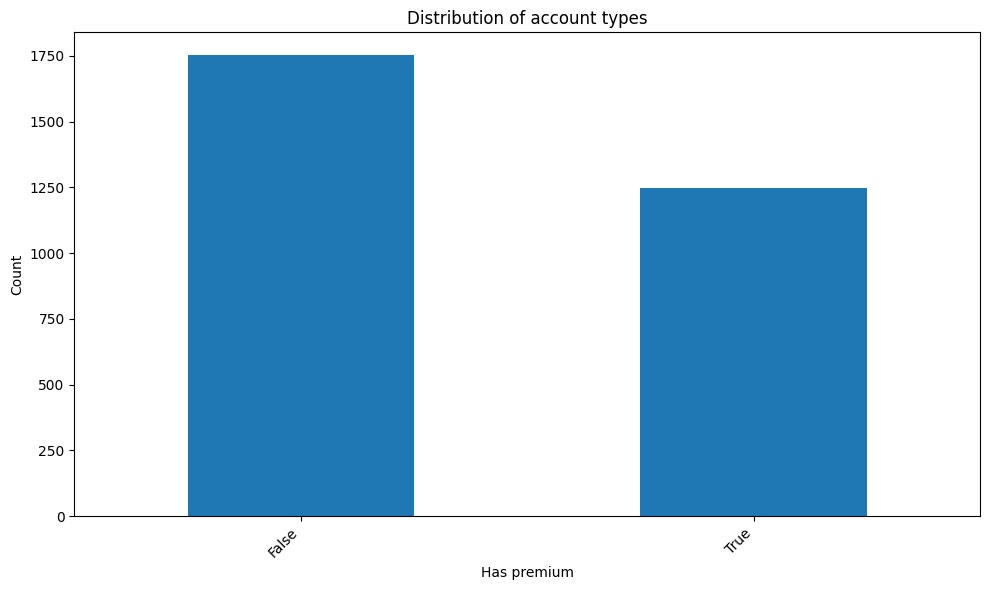

In [6]:
file_path = 'content/artists.jsonl'
artists = pd.read_json(file_path, lines=True, encoding='utf-8')

file_path = 'content/users.jsonl'
with open(file_path, 'r', encoding='utf-8') as file:
    users_dict = [json.loads(line) for line in file]

genre_counter = {}
for genres in artists['genres']:
    for genre in genres:
        genre_counter[genre] = genre_counter.get(genre, 0) + 1

user_counter = {}
for user in users_dict:
    for genre in user.get('favourite_genres', []):
        if genre not in user_counter:
            user_counter[genre] = [0, 0]  # [total_users, premium_users]
        user_counter[genre][0] += 1
        if user.get('premium_user', False):
            user_counter[genre][1] += 1

file_path = 'content/users.jsonl'
users_df = pd.read_json(file_path, lines=True, encoding='utf-8')
users_premium_counts = users_df['premium_user'].value_counts()

plt.figure(figsize=(10, 6))
users_premium_counts.plot(kind='bar')
plt.title("Distribution of account types")
plt.ylabel("Count")
plt.xlabel("Has premium")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

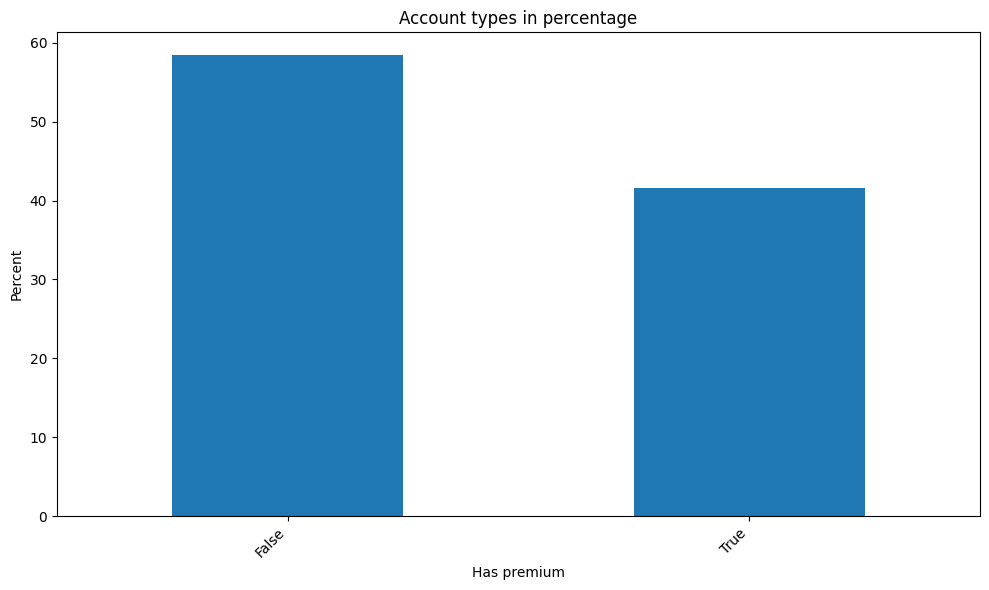

In [7]:
percentages = (users_premium_counts / users_premium_counts.sum()) * 100

plt.figure(figsize=(10, 6))
percentages.plot(kind='bar')
plt.title("Account types in percentage")
plt.ylabel("Percent")
plt.xlabel("Has premium")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Użytkownicy premium są w klasie mniejszościowej, ale stanowią znaczącą część wszystkich użytkowników (40% w porównaniu do 60% użytkowników nie-premium). 

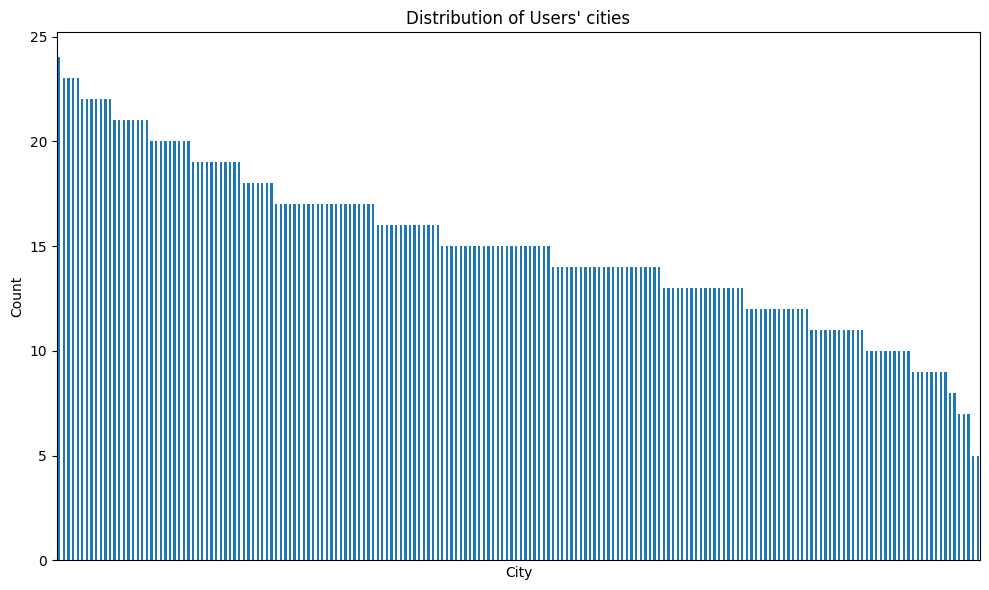

In [8]:
user_city_counts = users_df['city'].value_counts()

plt.figure(figsize=(10, 6))
user_city_counts.plot(kind='bar')
plt.title("Distribution of Users' cities")
plt.ylabel("Count")
plt.xlabel("City")
plt.xticks([])
plt.tight_layout()
plt.show()

Użytkownicy pochodzą z wielu miast. W niektórych mieszka ich więcej, ale nie ma znaczenie dominującej grupy miast o największej liczbie użytkowników.

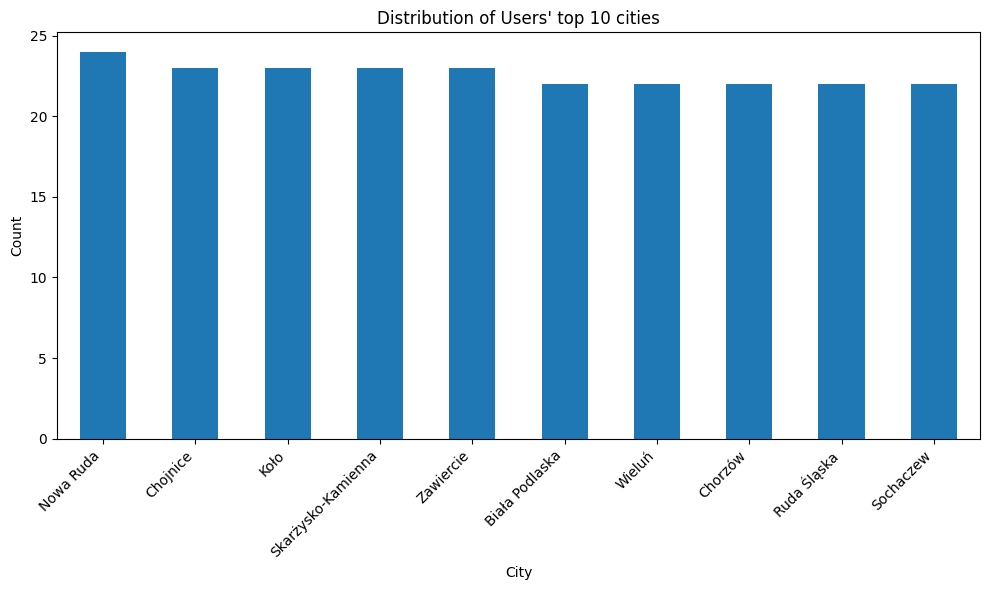

In [9]:
plt.figure(figsize=(10, 6))
user_city_counts.head(10).plot(kind='bar')
plt.title("Distribution of Users' top 10 cities")
plt.ylabel("Count")
plt.xlabel("City")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Nie są to wcale największe miasta.

10 miast o największej liczbie użytkowników

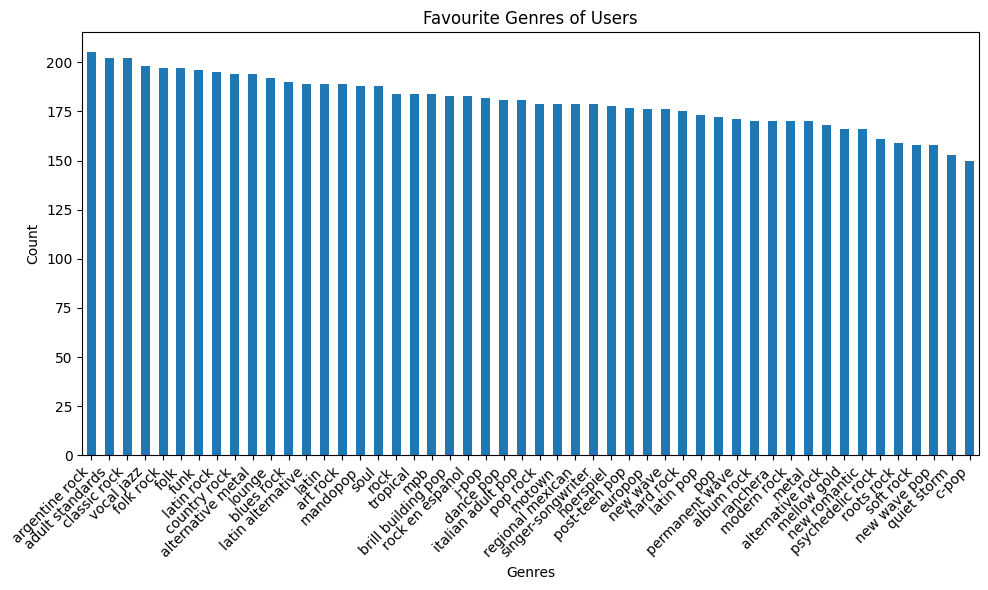

In [10]:
favourite_genres_flat = [genre for sublist in users_df['favourite_genres'] for genre in sublist]

genre_counts_users = pd.Series(favourite_genres_flat).value_counts()

plt.figure(figsize=(10, 6))
genre_counts_users.plot(kind='bar')
plt.title("Favourite Genres of Users")
plt.ylabel("Count")
plt.xlabel("Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Liczba użytkowników na ulubiony gatunek rozkłada się równomiernie.

- Dla zbioru 'artists':

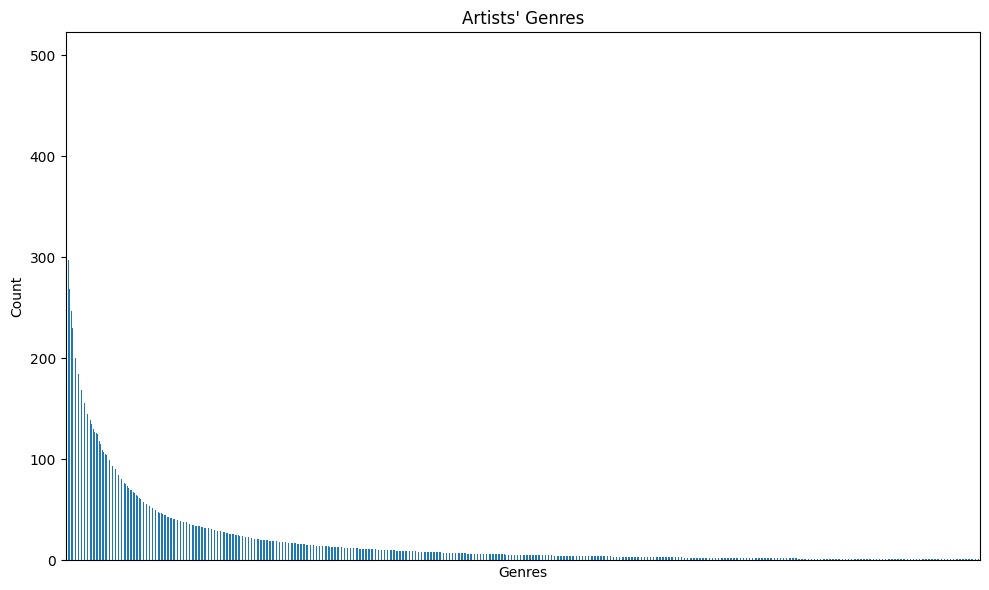

In [11]:
genres_flat = [genre for sublist in artists['genres'] for genre in sublist]

genre_counts_users = pd.Series(genres_flat).value_counts()

plt.figure(figsize=(10, 6))
genre_counts_users.plot(kind='bar')
plt.title("Artists' Genres")
plt.ylabel("Count")
plt.xlabel("Genres")
plt.xticks([])
plt.tight_layout()
plt.show()


Niektóre gatunki są nadreprezentowane przez artystów w porównaniu z innymi.

- Dla zbioru 'sessions':

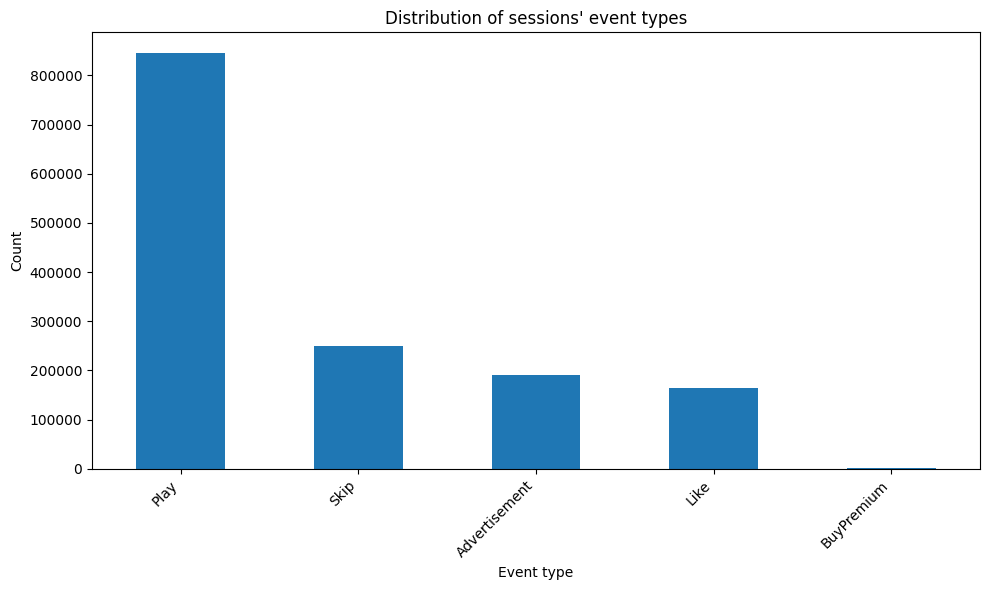

In [12]:
sessions_event_type_counts = sessions['event_type'].value_counts()

plt.figure(figsize=(10, 6))
sessions_event_type_counts.plot(kind='bar')
plt.title("Distribution of sessions' event types")
plt.ylabel("Count")
plt.xlabel("Event type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Zdecydowanie najczęstszym zdarzeniem jest odtworzenie utworu. Polubienie utworu, pominięcie i odtworzenie reklamy występuje z podobną częstością. Zakup konta jest możliwy raz na miesiac dla jednego konta dlatego występuje najrzadziej.

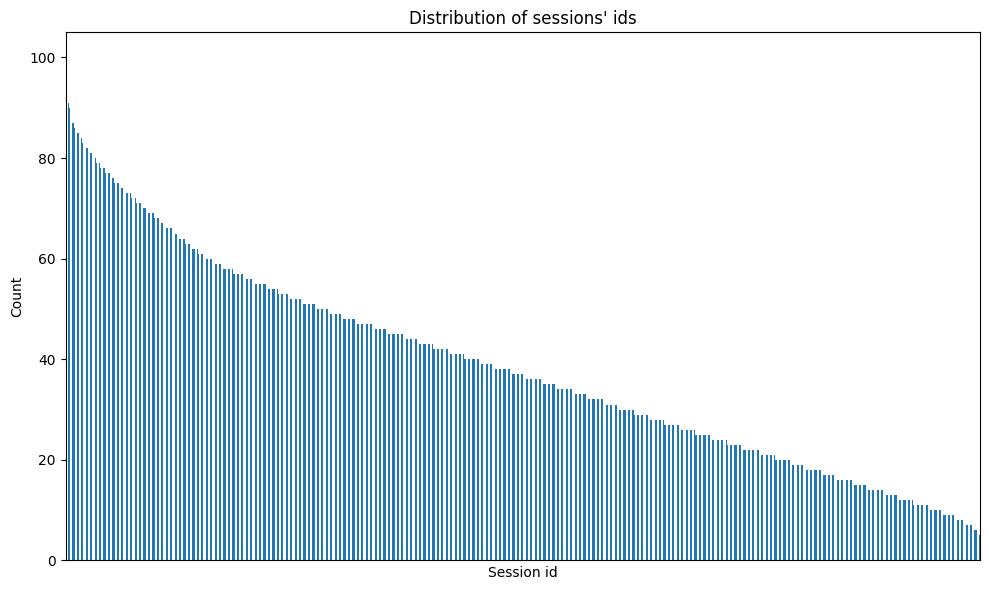

In [13]:
session_id_counts = sessions['session_id'].value_counts()

plt.figure(figsize=(10, 6))
session_id_counts.plot(kind='bar')
plt.title("Distribution of sessions' ids")
plt.ylabel("Count")
plt.xlabel("Session id")
plt.xticks([])
plt.tight_layout()
plt.show()

Sesje mają różną długość - liczbę zdarzeń, które były w ich czasie wykonane.

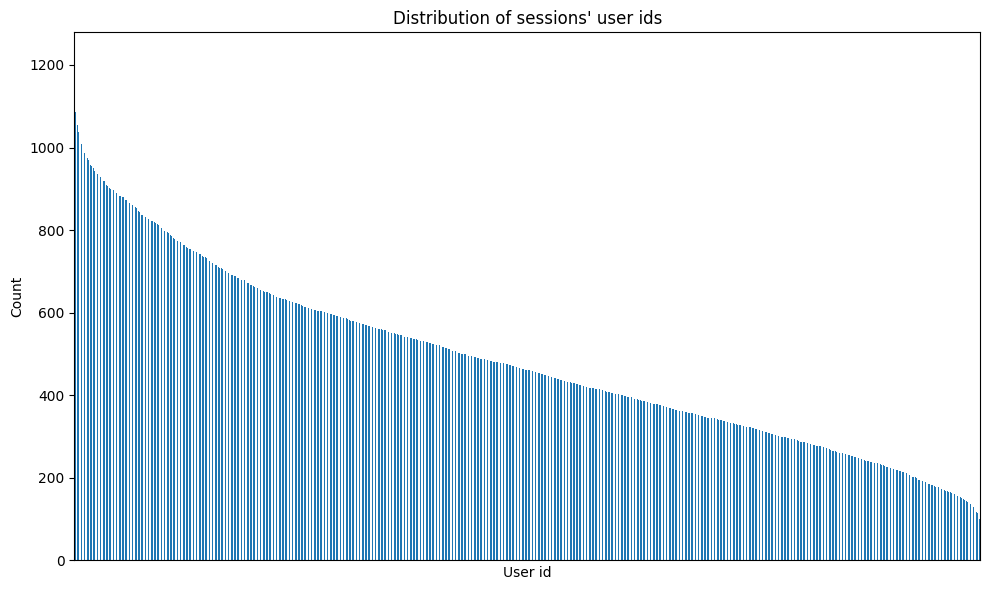

In [14]:
session_user_id_counts = sessions['user_id'].value_counts()

plt.figure(figsize=(10, 6))
session_user_id_counts.plot(kind='bar')
plt.title("Distribution of sessions' user ids")
plt.ylabel("Count")
plt.xlabel("User id")
plt.xticks([])
plt.tight_layout()
plt.show()

Ten wykres jest spójny z wykresem przedstawiającym id sesji. "Dłuższe" sesje - o większej liczbie wpisów o zdarzeniach - mają powtarzające się id użytkownika.

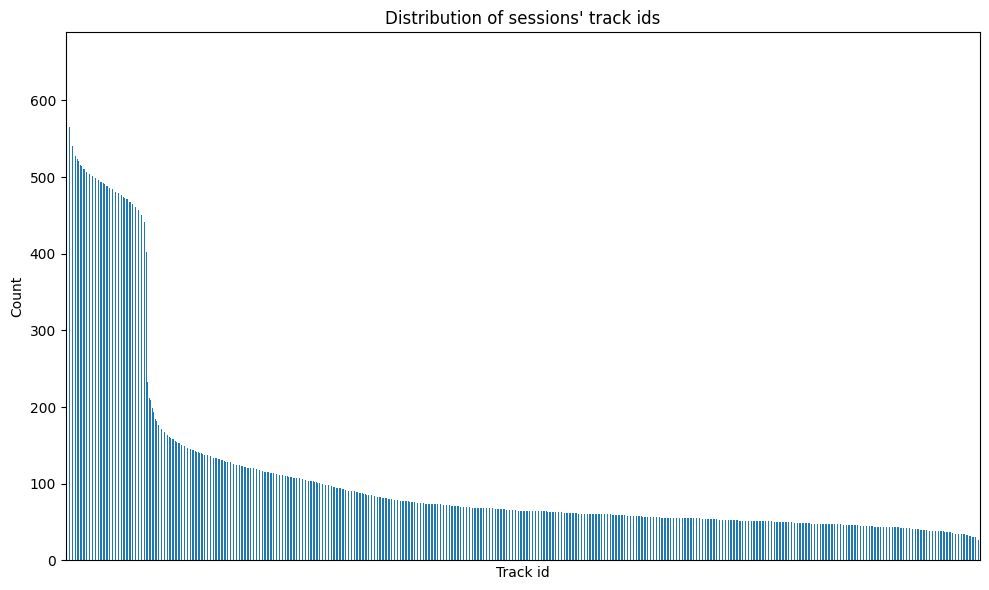

In [15]:
session_user_id_counts = sessions['track_id'].value_counts()

plt.figure(figsize=(10, 6))
session_user_id_counts.plot(kind='bar')
plt.title("Distribution of sessions' track ids")
plt.ylabel("Count")
plt.xlabel("Track id")
plt.xticks([])
plt.tight_layout()
plt.show()

Część utworów jest znacznie częściej odtwarzana od innych.

- Dla zbioru 'tracks':

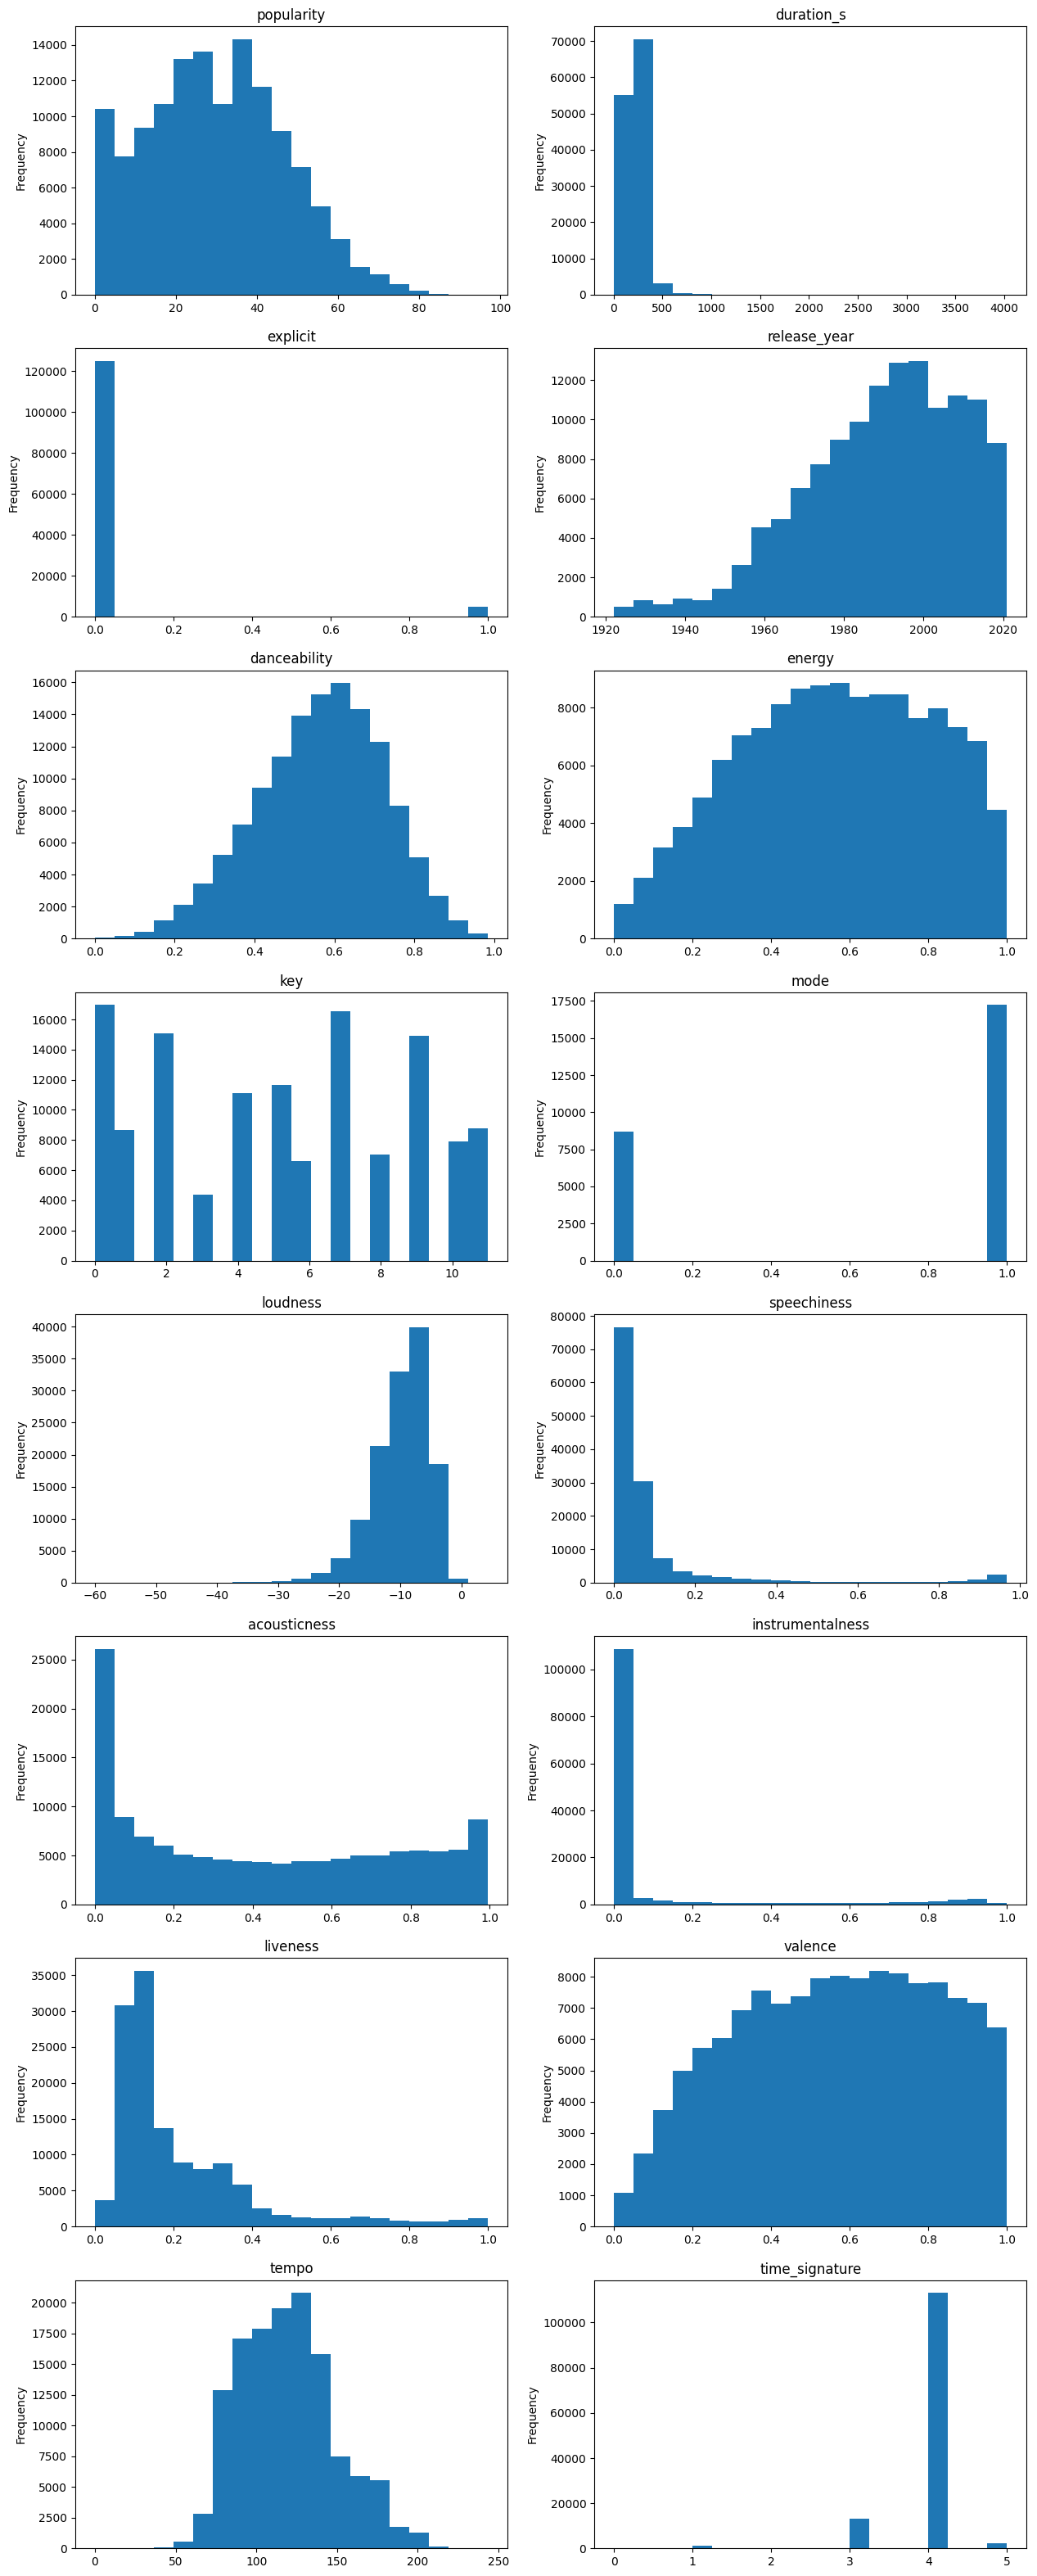

In [16]:
tracks['release_year'] = tracks['release_date'].str[:4].astype(int) 
#okazało się, że część danych w tej kolumnie to sam rok, a część ma też miesiac i dzień po myślniku

tracks['duration_s'] = tracks['duration_ms'] / 1000

X = tracks[[#'id', 'artist_id', 'name',
    'popularity', #'duration_ms',
    'duration_s', 'explicit', #'release_date',
    'release_year', 'danceability', 'energy', 'key', 'mode', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'time_signature']]

n_attributes = len(X.keys())

n_cols = 2  
n_rows = (n_attributes // n_cols) + (n_attributes % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

axes = axes.flatten()

for idx, (x, ax) in enumerate(zip(X.keys(), axes)):
    X[x].plot(kind="hist", bins=20, ax=ax)
    ax.set_title(f"{x}")
    # ax.set_xlabel(x) 
    ax.set_ylabel('Frequency')  

for idx in range(n_attributes, len(axes)):
    axes[idx].axis('off')

plt.show()


Dane o dacie publikacji okazały się nieustandaryzowane - wartości tego atrybuty miały różną szczegółowość (z dokładnością do roku lub dnia), dlatego stworzyliśmy atrybut rok publikacji ('release_year'). Wyświetlanie długości trwania utworu w milisekundach również było niepraktyczne, więc dodaliśmy atrybut długość w sekundach ('duration_s').

Znaczna większość utworów jest krótsza niż 500 sekund (ale są też dłuższe niż 3000 sekund), nie jest 'explicit' ani głośna ('loudness'), zawiera mało fragmentów mówionych ('speechiness') i instrumentalnych ('instrumentalness') oraz ma metrum 4/4 ('time_signature==4').
Większość ma tonalność durową ('mode==1'), pochodzi z ostatnich 40 lat, nie jest akustyczna ('acousticness'), żywiołowa ('liveness') ani bardzo popularna ('popularity').
Pozostałe cechy: tanczeność ('danceability'), energiczność ('energy'), tonacja ('key'), wesołość ('valence'), tempo ('tempo') mają rozkład zbliżony do normalnego (krzywej dzwonowej), czyli są w miare zróżnicowane.


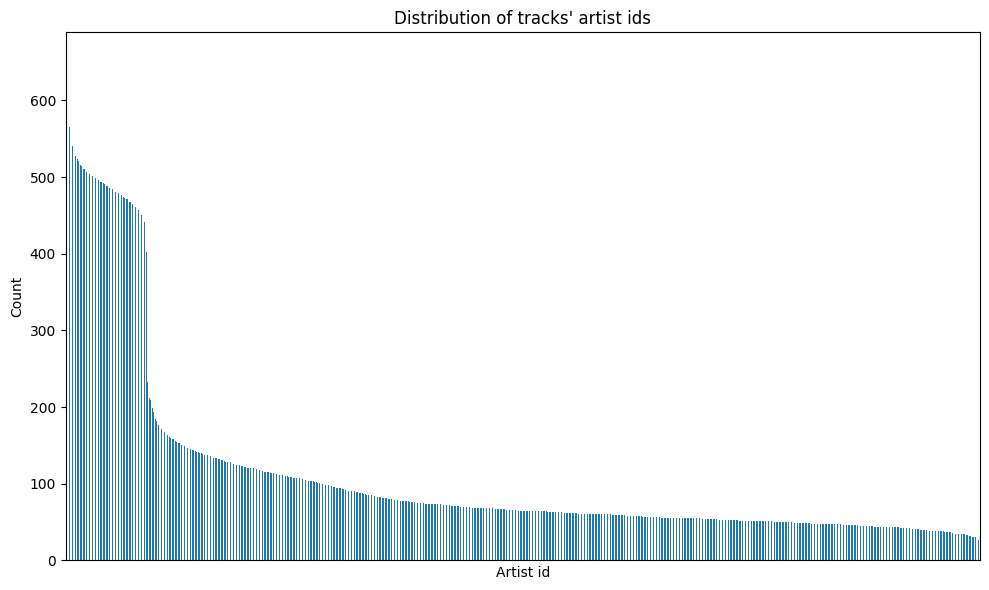

In [17]:
tracks_artist_id_counts = tracks['artist_id'].value_counts()

plt.figure(figsize=(10, 6))
session_user_id_counts.plot(kind='bar')
plt.title("Distribution of tracks' artist ids")
plt.ylabel("Count")
plt.xlabel("Artist id")
plt.xticks([])
plt.tight_layout()
plt.show()

Niektórzy artyści mają więcej utworów w serwisie muzycznym.

- Dla zbioru 'tracks_storage':

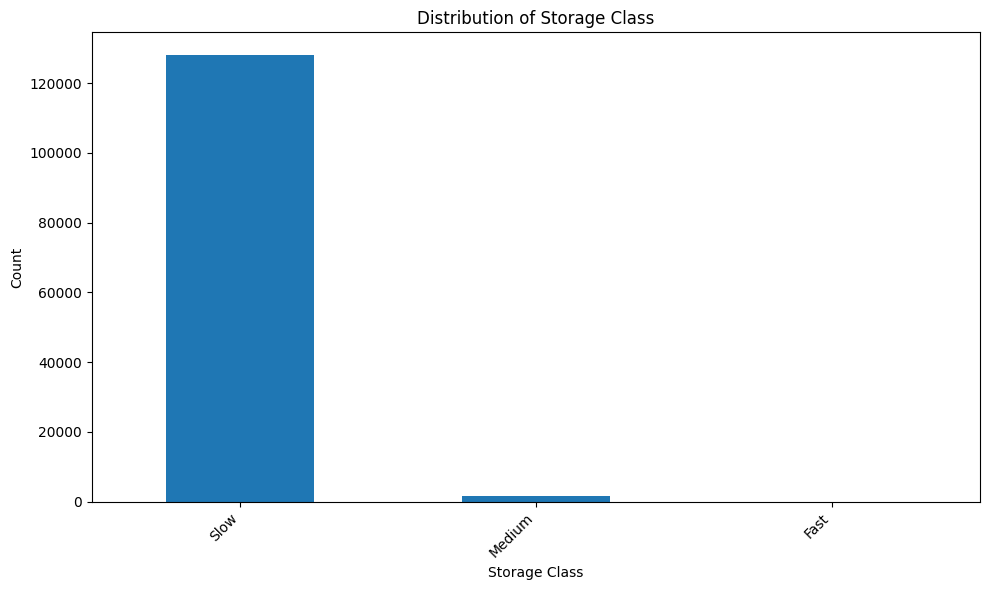

In [18]:
storage_class_counts = track_storage['storage_class'].value_counts()

plt.figure(figsize=(10, 6))
storage_class_counts.plot(kind='bar')
plt.title("Distribution of Storage Class")
plt.ylabel("Count")
plt.xlabel("Storage Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Niemal wszystkie utwory są przechowywane w formacie charakteryzującym się powolnym dostępem.

---

#### Reprezentatywność wygenerowanych atrybutów

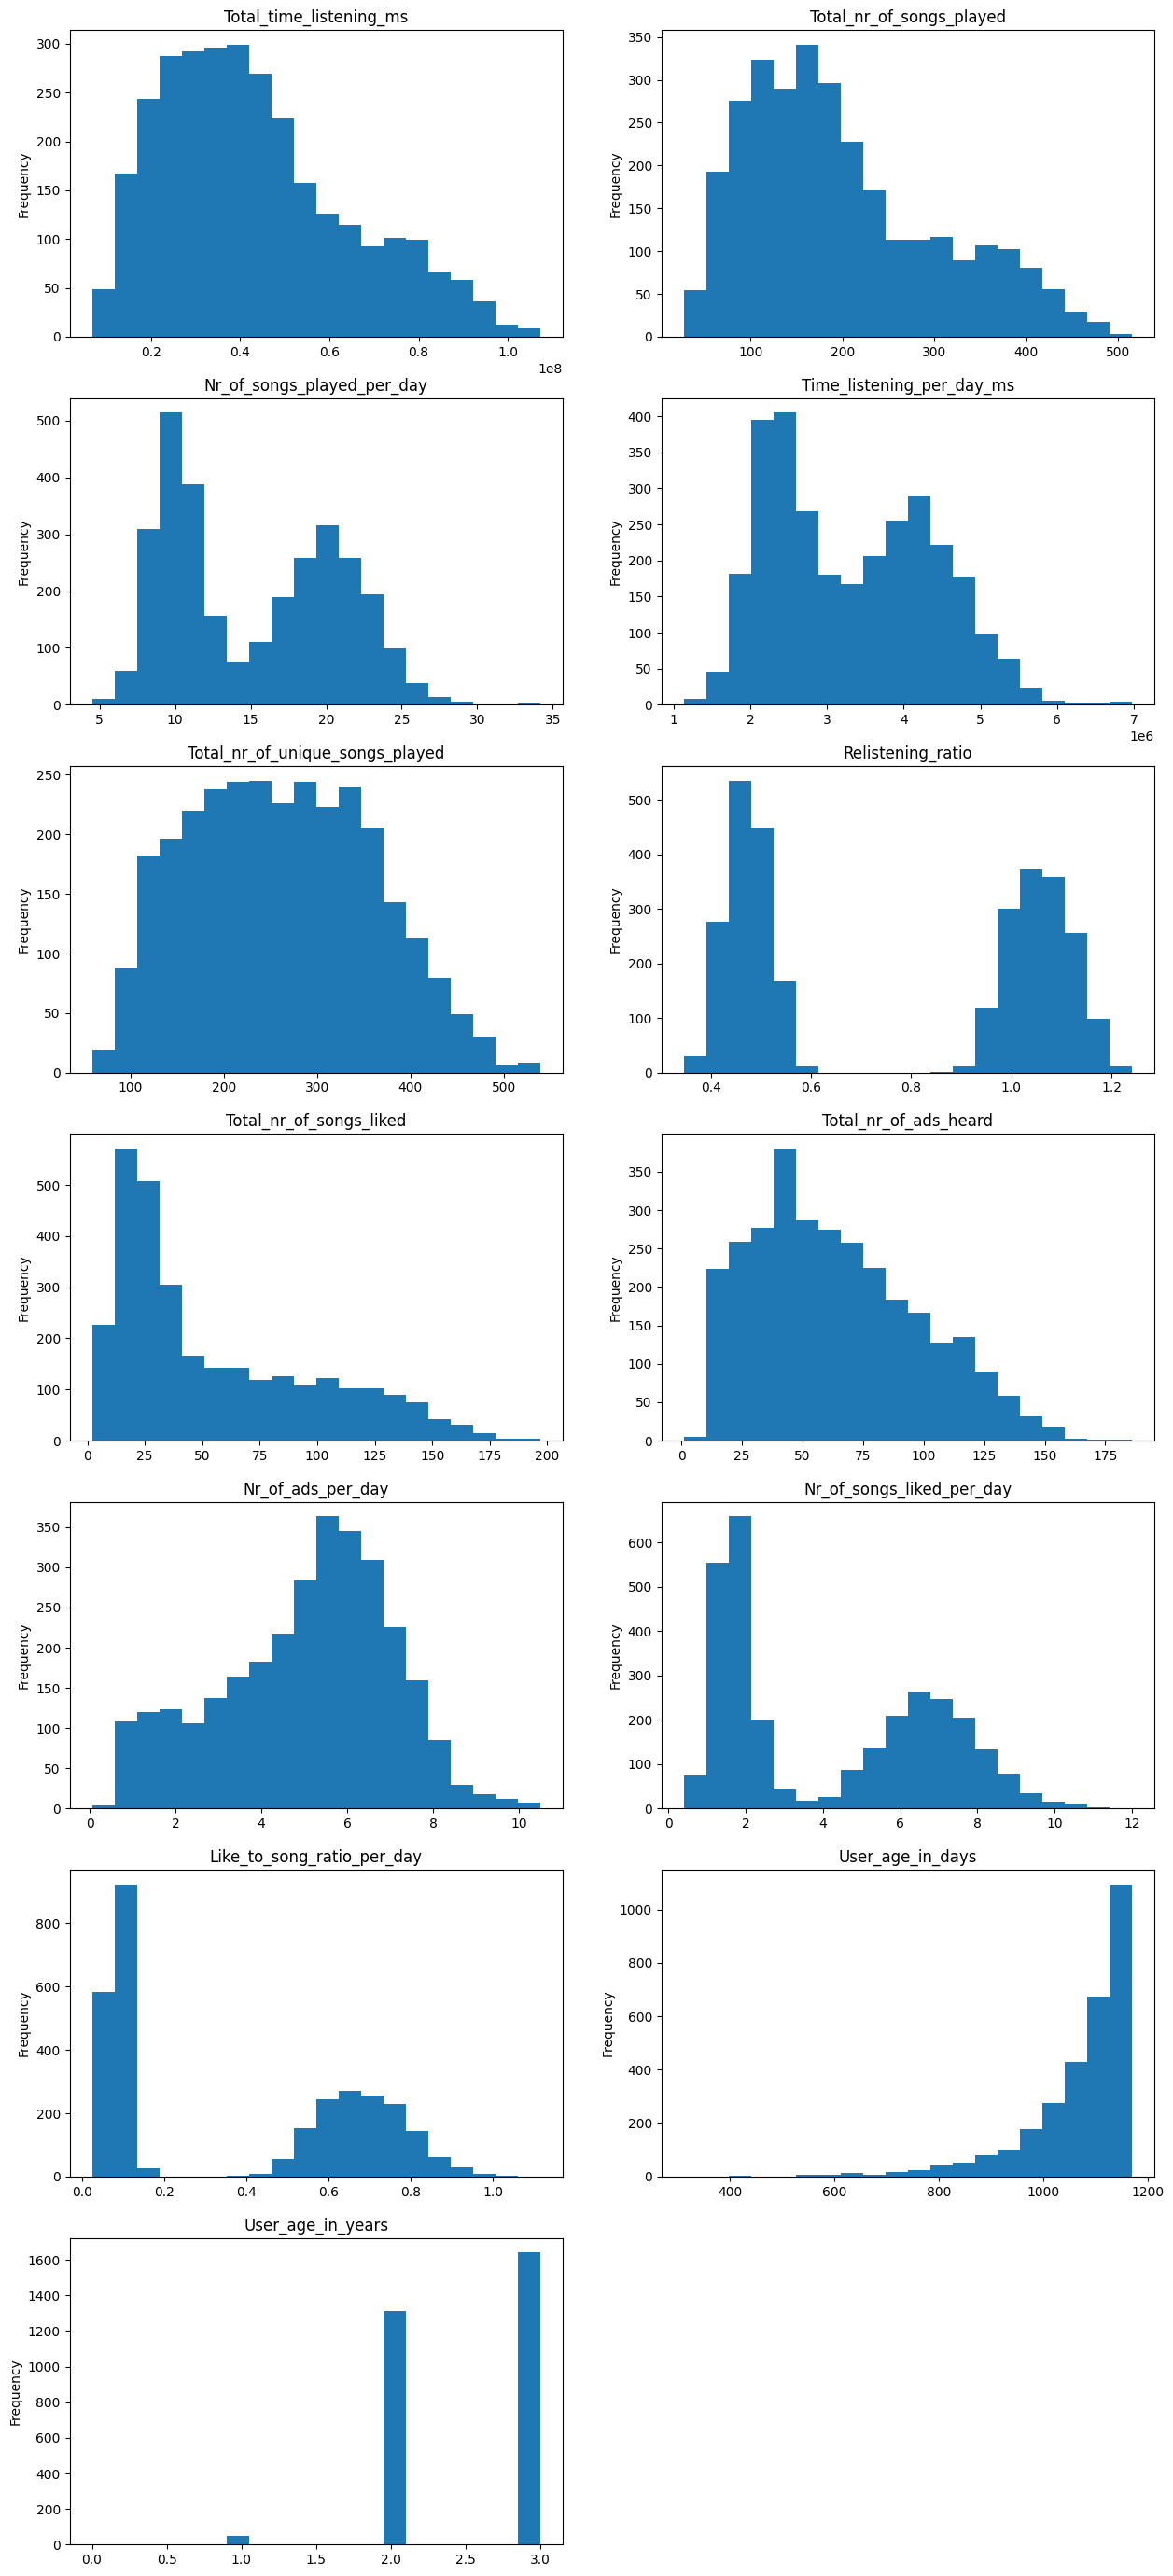

In [19]:
X = users[['Total_time_listening_ms', 'Total_nr_of_songs_played',
       'Nr_of_songs_played_per_day', 'Time_listening_per_day_ms',
       'Total_nr_of_unique_songs_played', 'Relistening_ratio',
       'Total_nr_of_songs_liked', 'Total_nr_of_ads_heard', 'Nr_of_ads_per_day',
       'Nr_of_songs_liked_per_day', 'Like_to_song_ratio_per_day',
       'User_age_in_days', 'User_age_in_years']]

Y = users[['is_premium']]

n_attributes = len(X.keys())

n_cols = 2  
n_rows = (n_attributes // n_cols) + (n_attributes % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

axes = axes.flatten()

for idx, (x, ax) in enumerate(zip(X.keys(), axes)):
    X[x].plot(kind="hist", bins=20, ax=ax)
    ax.set_title(f"{x}")
    # ax.set_xlabel(x) 
    ax.set_ylabel('Frequency')  

for idx in range(n_attributes, len(axes)):
    axes[idx].axis('off')

plt.show()


---

#### Informatywność podstawowych atrybutów

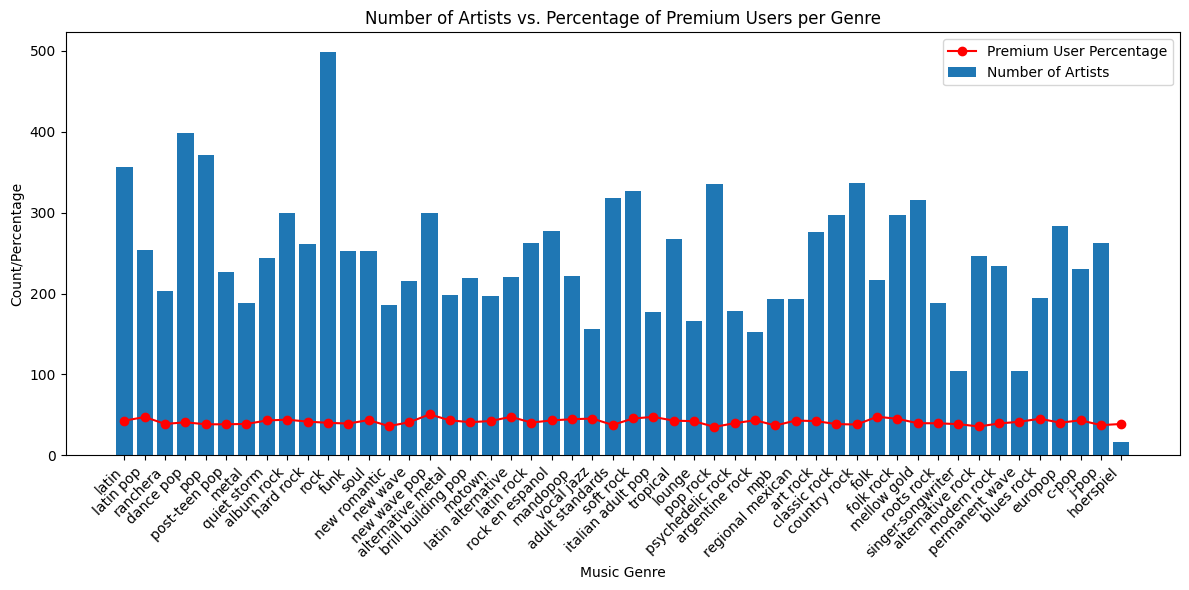

In [20]:
for genre, counts in user_counter.items():
    total_users, premium_users = counts
    user_counter[genre] = [premium_users, premium_users / total_users]

genres = list(genre_counter.keys())
gg = genres.copy()
num_bands = list(genre_counter.values())
premium_percentage = []
for genre in gg:
  if genre in user_counter:
    premium_percentage.append(user_counter[genre][1] * 100)
  else:
    num_bands.pop(genres.index(genre))
    genres.remove(genre)

plt.figure(figsize=(12, 6))
plt.bar(genres, num_bands, label='Number of Artists')
plt.plot(genres, premium_percentage, marker='o', color='red', label='Premium User Percentage')

plt.xlabel('Music Genre')
plt.ylabel('Count/Percentage')
plt.title('Number of Artists vs. Percentage of Premium Users per Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
print()

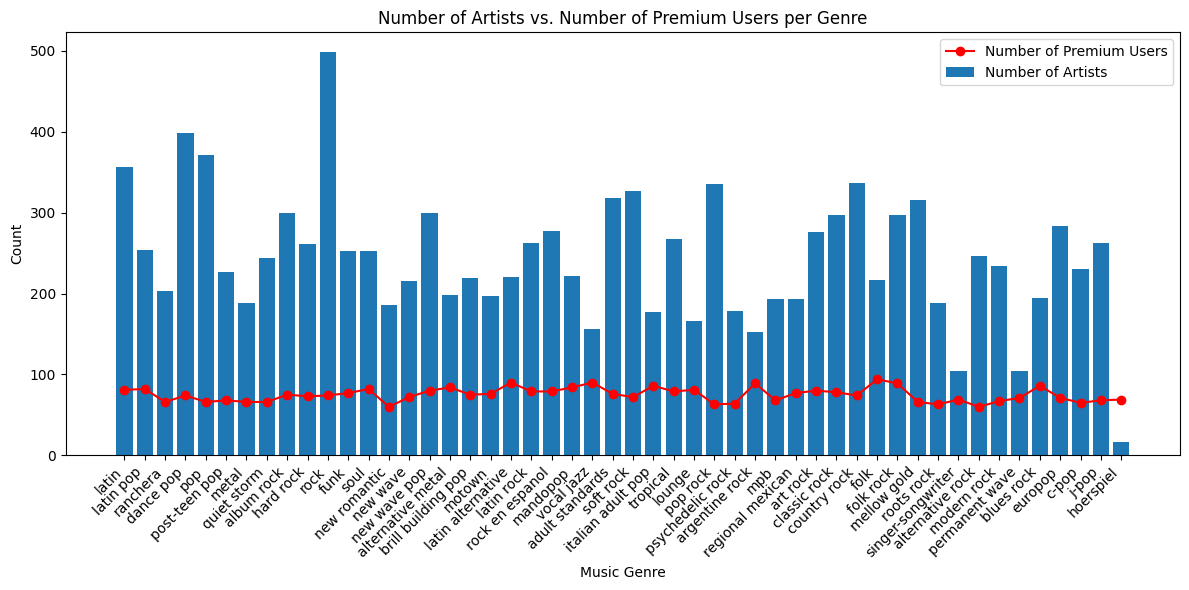

In [21]:
premium_users = [user_counter[genre][0] for genre in genres]
plt.figure(figsize=(12, 6))
plt.bar(genres, num_bands, label='Number of Artists')
plt.plot(genres, premium_users, marker='o', color='red', label='Number of Premium Users')

plt.xlabel('Music Genre')
plt.ylabel('Count')
plt.title('Number of Artists vs. Number of Premium Users per Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

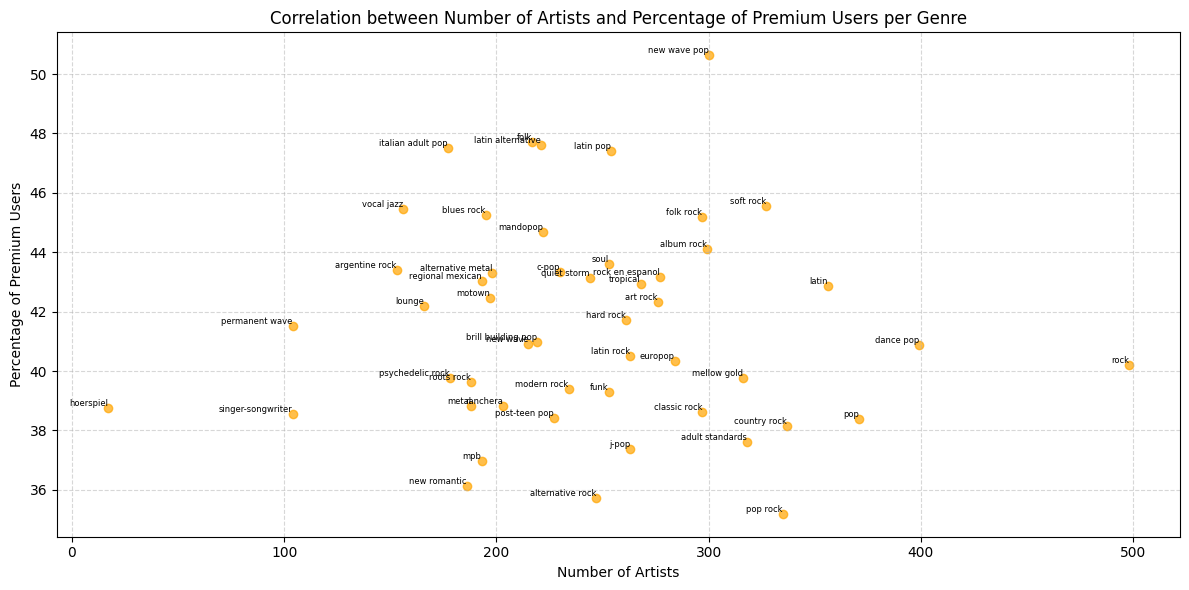

In [22]:
plt.figure(figsize=(12, 6))
plt.scatter(num_bands, premium_percentage, color='orange', alpha=0.7)

for i, genre in enumerate(genres):
    if genre in user_counter:
        plt.text(num_bands[i], premium_percentage[i], genre, fontsize=6, ha='right', va='bottom')

plt.xlabel('Number of Artists')
plt.ylabel('Percentage of Premium Users')
plt.title('Correlation between Number of Artists and Percentage of Premium Users per Genre')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Rozmieszczenie użytkowników pozytywki na mapie:

In [23]:
%pip install folium
%pip install geopy
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

cities = {}
for user in users_dict:
  city = user.get('city')
  if city not in cities:
    cities[city] = [cities.get(city, 0) + 1, 1 if user.get('premium_user') else 0]
  else:
    cities[city][0] += 1
    cities[city][1] += 1 if user.get('premium_user') else 0

geolocator = Nominatim(user_agent="geoapi")

locations = []
for city, users in cities.items():
    location = geolocator.geocode(city + ", Poland")
    if location:
        locations.append((location.latitude, location.longitude, users[0]))

m = folium.Map(location=[52.237049, 21.017532], zoom_start=6)  # Centrum Polski

heat_data = [(lat, lon, count) for lat, lon, count in locations]
HeatMap(heat_data).add_to(m)
# m.save("poland_heatmap.html")

m


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


<Figure size 1000x500 with 0 Axes>

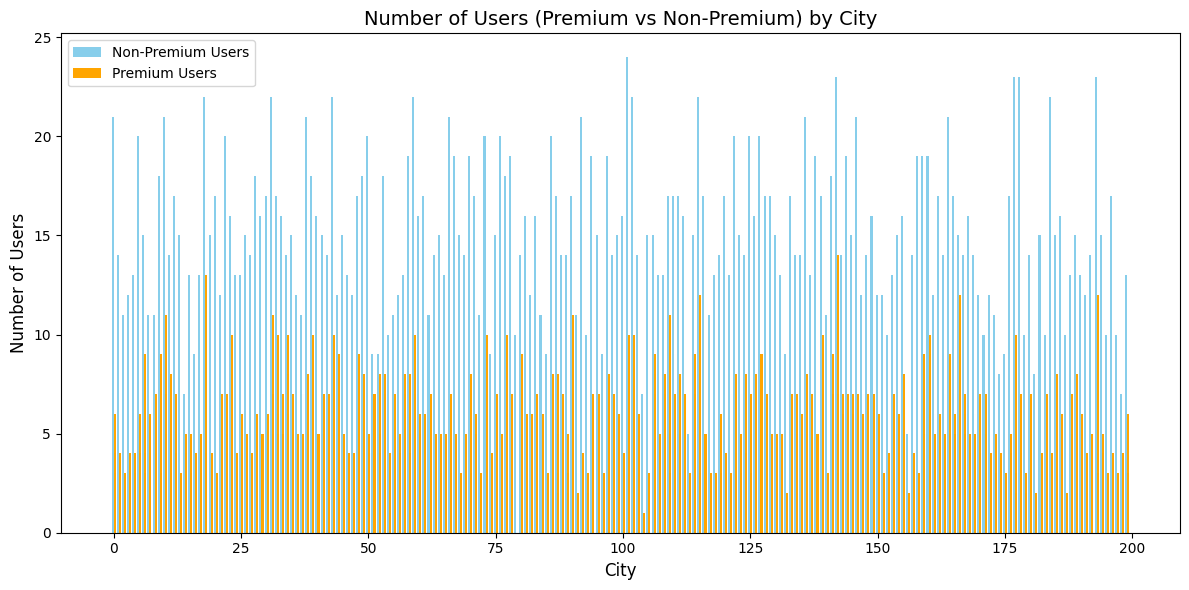

In [24]:
plt.figure(figsize=(10, 5))
keys = list(cities.keys())
values = [value[0] for value in cities.values()]
premium = [value[1] for value in cities.values()]


x = np.arange(len(keys))
bar_width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, values, width=bar_width, color='skyblue', label='Non-Premium Users')
plt.bar(x + bar_width / 2, premium, width=bar_width, color='orange', label='Premium Users')
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('Number of Users (Premium vs Non-Premium) by City', fontsize=14)

# plt.xticks(x, keys, rotation=90, ha='right', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()


Z powyższych wykresów wynika, że to jakiej muzyki słuchają użytkownicy, oraz to gdzie mieszkają nie koreluje z tym jaka ich część ma konta premium.


In [ ]:
file_path = 'content/sessions.jsonl'
with open(file_path, 'r', encoding='utf-8') as file:
    sessions_dict = [json.loads(line) for line in file]

session_skip = {}
for session in sessions_dict:
    session_id = session['session_id']
    if session_id not in session_skip:
        session_skip[session_id] = [session['user_id'], 0]
    if session['event_type'] == 'Skip':
        session_skip[session_id][1] += 1

user_skip = {}
for user, skips in session_skip.values():
    if user not in user_skip:
        user_skip[user] = [0, 0] #[skips, sessions]
    user_skip[session_id][0] += skips
    user_skip[session_id][0] += skips

---

#### Informatywność podstawowych atrybutów

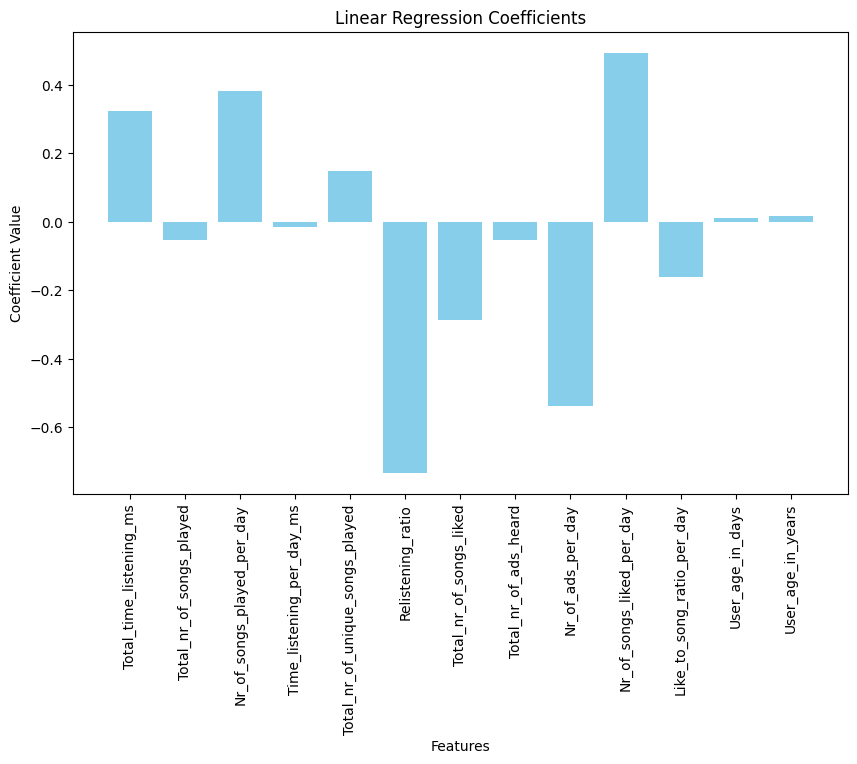

Bias: [-0.168]
Index(['Total_time_listening_ms', 'Total_nr_of_songs_played',
       'Nr_of_songs_played_per_day', 'Time_listening_per_day_ms',
       'Total_nr_of_unique_songs_played', 'Relistening_ratio',
       'Total_nr_of_songs_liked', 'Total_nr_of_ads_heard', 'Nr_of_ads_per_day',
       'Nr_of_songs_liked_per_day', 'Like_to_song_ratio_per_day',
       'User_age_in_days', 'User_age_in_years'],
      dtype='object')
Coefficient: [[ 0.32243879 -0.05382011  0.38339857 -0.01474987  0.1481715  -0.73346914
  -0.28635965 -0.05223808 -0.53841959  0.49252868 -0.16010835  0.01193219
   0.01713266]]


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Standaryzacja wartości w X
scaler = StandardScaler()

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# print(X_standardized)

model = LinearRegression()

# Fit the model to the data
model.fit(X_standardized, Y)
Yp = model.predict(X_standardized)

feature_names = [f'{str(i)}' for i in X_standardized.keys()]  # Change if you have actual names
weights = model.coef_[0]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(feature_names, model.coef_[0], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.xticks(rotation=90)
plt.show()

# Get the regression coefficients (parameters)
print("Bias:", model.intercept_)
print(X.keys())
print("Coefficient:", model.coef_)

Dopasowaliśmy model regresji do wygenerowanych atrybutów by sprawdzić, które najlepiej pomogą nam przewidywać typ konta użytkownika i otrzymaliśmy powyższe wagi

In [27]:
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
print("MSE:", mean_squared_error(Y, np.sign(Yp)))
print("R2:", r2_score(Y,np.sign(Yp)))
conf_mat = confusion_matrix(Y,np.sign(Yp))
print("Confusion Matrix:", conf_mat)
# print([1 for v in Y.values if v == 1 ])
print(f"Y 1s: {sum([1 for v in Y.values if v == 1 ])}  0s: {sum([1 for v in Y.values if v == -1 ])}")
print(f"Yp 1s: {sum([1 for v in np.sign(Yp) if v == 1])}, 0s: {sum([1 for v in np.sign(Yp) if v == -1])}")

# TN = conf_mat[0][0]
# FP = conf_mat[0][1]
# FN = conf_mat[1][0]
# TP = conf_mat[1][1]

# precision = TP / (TP + FP) 
# print("\nPrecision: ", precision)
# accuracy = (TP + TN) / (TP + TN + FP + FN)
# print("Accuracy: ", accuracy)
# recall = TP / (TP + FN) 
# print("Recall: ", recall)
# f1_score = (2 * precision * recall) / (precision + recall) 
# print("F1_score: ", f1_score)

MSE: 0.43466666666666665
R2: 0.5527089919213206
Confusion Matrix: [[1743    9]
 [ 317  931]]
Y 1s: 1248  0s: 1752
Yp 1s: 940, 0s: 2060


Model wyjaśnia 55% zmienności. MSE wynosi 0.436.